In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import numpy as np
import pandas as pd
import sympy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from solvers import laplace_fdm,laplace_fdm_inhomogeneus,laplace_GP,laplace_spectral
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [11]:
X_visualization,Y_visualization=np.meshgrid(np.arange(0.0, 1.0, 0.01), np.arange(0.0, 1.0, 0.01))

def plot_vectorized_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Z=f(X_visualization,Y_visualization)

    ax.plot_surface(X_visualization, Y_visualization, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig


# Introduction

This notebook is used to generate our data. We have coded several solvers in `solvers.py`, and will sample random solution function to get our dataset. To ensure reproducibility, we have saved the parameters sampled in `parameters_functions.csv`. Still, we include the sampling procedure for the samples as well. 

# Define the sampling of functions

In [5]:
def random_parameters():
    point=np.random.rand(2)
    max_freq=5*sympy.pi*np.random.rand()
    lengthscale_bounds=np.array([1e-1,0.5])
    lengthscale=10**(np.log10(lengthscale_bounds[0])+np.random.rand()*(np.log10(lengthscale_bounds[1])-np.log10(lengthscale_bounds[0])))
    params={'theta':0,'mu_0':point[0],'mu_1':point[1],'l':lengthscale,'l_r':1,'M_f':max_freq}
    return params

# The following code can be used to generate the dataset of random parameters
'''np.random.seed(0)
N=601
params_list=[]
for i in range(N):
    params_list.append(random_parameters())
params_df=pd.DataFrame(params_list)
params_df.to_csv('random_parameters_2.csv',index=False)'''

In [6]:
def make_sympy_func():
    x,y,lengthscale,theta,lengthscale_ratio,mu_0,mu_1,max_freq=sympy.symbols('x y l theta l_r mu_0 mu_1 M_f')

    rot=sympy.Matrix([[sympy.cos(theta),-sympy.sin(theta)],[sympy.sin(theta),sympy.cos(theta)]])
    l=sympy.Matrix([[lengthscale_ratio,0],[0,1/lengthscale_ratio]])/lengthscale**2/2
    M=rot.T*l*rot
    v=sympy.Matrix([x-mu_0,y-mu_1])
    u=sympy.sin(sympy.pi*x)*sympy.sin(sympy.pi*y)*sympy.sin(max_freq*sympy.exp(-(v.dot(M*v))))
    uxx=sympy.diff(u,x,x)
    uyy=sympy.diff(u,y,y)
    f=uxx+uyy
    return {
        'u':u,
        'f':f,
        'x':x,
        'y':y,
        'l':lengthscale,
        'theta':theta,
        'l_r':lengthscale_ratio,
        'mu_0':mu_0,
        'mu_1':mu_1,
        'M_f':max_freq
        }

def do_eval(expr,sympy_utils,values):
    dict_values={sympy_utils[k]:v for k,v in values.items()}
    return sympy_utils[expr].xreplace(dict_values)
    
sympy_utils=make_sympy_func()

--- 0.018644332885742188 seconds to substitute values---


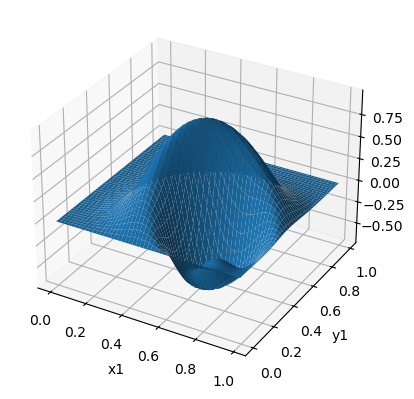

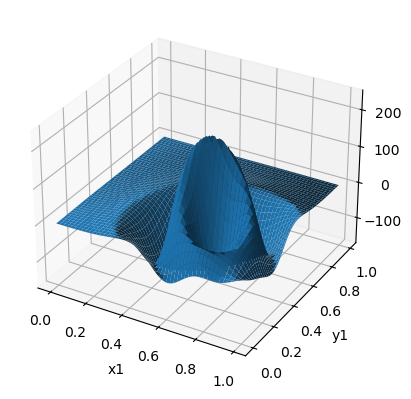

In [13]:
df=pd.read_csv(f'parameters_functions.csv',index_col=0)


def make_u_f(sympy_utils,df,i,**kwargs):
    if i<len(df):
        subs={k:df[k][i] for k in df.columns}
        try:
            subs['M_f']=float(subs['M_f'].replace('*','').replace('pi',''))*sympy.pi
        except:
            pass


    u=do_eval('u',sympy_utils,subs)
    f=do_eval('f',sympy_utils,subs)
    x_sympy,y_sympy=sympy_utils['x'],sympy_utils['y']
    u=sympy.lambdify((x_sympy,y_sympy),u,'numpy')
    f=sympy.lambdify((x_sympy,y_sympy),f,'numpy')
    return u,f

import time
start_time = time.time()
u_trial,f_trial=make_u_f(sympy_utils,df,0)
print("--- %s seconds to substitute values---" % (time.time() - start_time))
fig = plot_vectorized_function(u_trial)
fig2=plot_vectorized_function(f_trial)

# Define solvers

**Note on the GP solver**: In the collocation points of the GP were randomly sampled, with no seed. Thus, the result of our experiments are not exactly reproducible. If you need the exact solutions found in the paper to reproduce our findings, please contact the authors or owner of the repository to get a copy. 

In [22]:
N_target=50
X_grid,Y_grid = np.meshgrid(np.linspace(0,1,N_target+1,endpoint=True),np.linspace(0,1,N_target+1,endpoint=True))

solver_fdm_asym_left=laplace_fdm_inhomogeneus(
    N1=30,
    N2=30,
    L1=0.4,
    L2=0.6,
    N_target=N_target)
solver_fdm_asym_right=laplace_fdm_inhomogeneus(
    N1=30,
    N2=30,
    L1=0.6,
    L2=0.4,
    N_target=N_target)
solver_fdm=laplace_fdm(N=40,N_target=N_target)
solver_GP=laplace_GP(N=500,N_target=N_target)
solver_spectral=laplace_spectral(N=40,N_target=N_target)
solvers=[solver_fdm_asym_left,solver_fdm_asym_right,solver_fdm,solver_GP,solver_spectral]
names=['fdm_asym_left','fdm_asym_right','fdm','GP','spectral']

fdm_asym_left time to solve 0.0021860599517822266


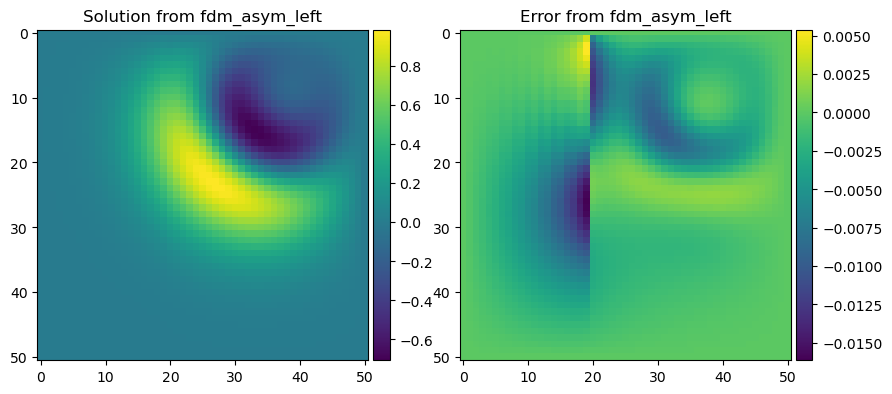

fdm_asym_right time to solve 0.0017011165618896484


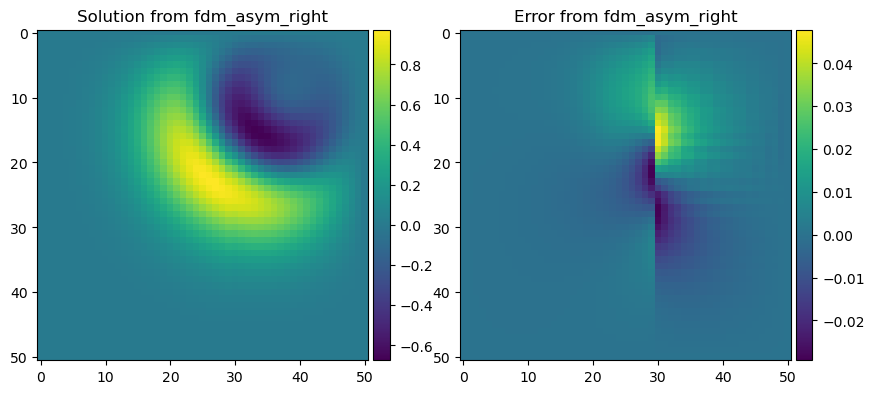

fdm time to solve 0.0008418560028076172


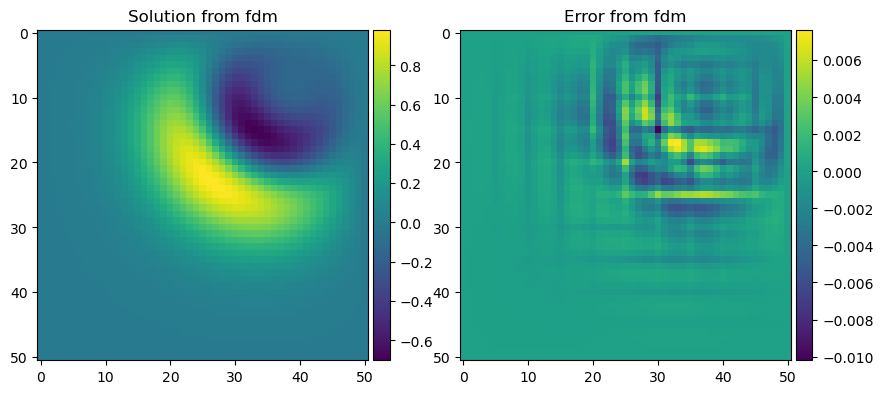

GP time to solve 0.0004901885986328125


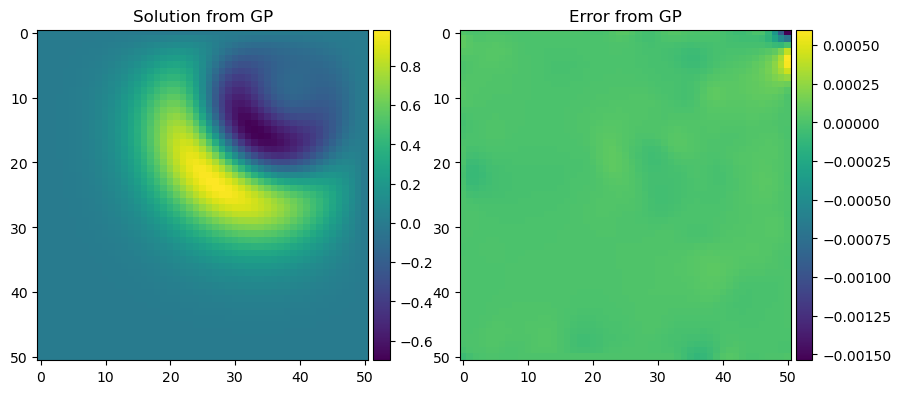

spectral time to solve 0.0015420913696289062


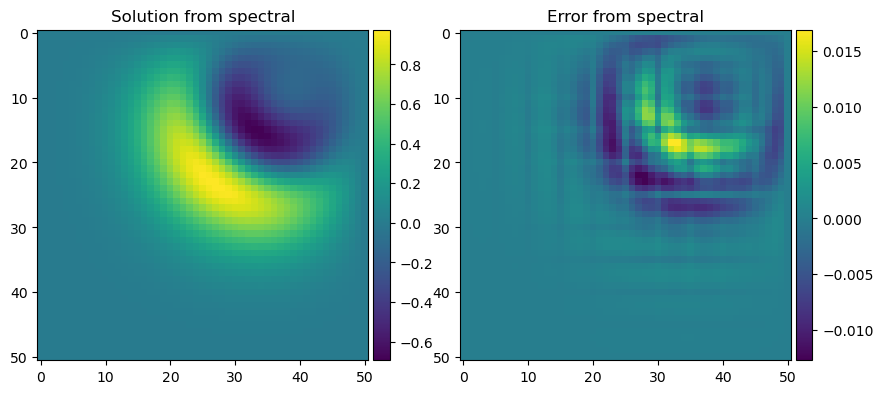

In [23]:
u_grid=u_trial(X_grid,Y_grid)
sols=[]
start=time.time()
for solver,name in zip(solvers,names):
    sol=solver(f_trial)
    print(name,'time to solve',time.time()-start)
    #make two plots as subplots
    fig,axs=plt.subplots(1,2,figsize=(10,5))
    im1=axs[0].imshow(sol)
    axs[0].set_title('Solution from '+name)
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    im2 = axs[1].imshow(sol-u_grid)
    axs[1].set_title('Error from '+name)
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    plt.show()
    start=time.time()

# Generate the data

In [ ]:
UF=[make_u_f(sympy_utils,df,i=k+1) for k in tqdm(range(600), desc="sampling u and f")]
U=np.stack([uf[0] for uf in UF],axis=0)
F=np.stack([uf[1] for uf in UF],axis=0)

for i,f in tqdm(enumerate(F)):
    np.save(f'data/u/u_{i}.npy',U[i](X_grid,Y_grid))
    np.save(f'f/f_{i}.npy',f(X_grid,Y_grid))
    for solver,name in zip(solvers,names):
        sol=solver(f_trial)
        np.save(f'data/{name}/sol_{i}.npy',sol)